# **Construindo um modelo de Regressão para marketing**
**Autor:** **Gilson Machado**

## Entendendo o problema

Uma empresa está investindo mensalmente em plataformas de publicidade, como Youtube, Facebook e newspaper, para a prospecção de leads (pessoas interessadas em seus produtos). A fim de acompanhar o desempenho desses investimentos, a empresa registra todos os gastos com publicidade e todos os retornos de vendas gerados a partir desses investimentos.

####Objetivo do projeto:
Criar uma análise exploratória que mostre a correlação entre os investimentos e as vendas, além de um modelo que irá prever o total de vendas gerado a partir de um investimento em uma plataforma de mídia usando como base os dados sobre investimentos anteriores.

### Planejamento do projeto

O projeto foi estruturado nas seguintes fases:

1.  **Análise descritiva**
2.  **Tratamento dos dados**
3.  **Análise exploratória**
4.  **Criação do modelo**
5.  **Teste do modelo**
6.  **Avaliação geral**

### Avaliação inicial das ferramentas e técnicas.

O projeto será realizado com as seguintes bibliotecas:

*   Pandas
*   Seaborn
*   SKLearn
*   Google Colab
*   Matplotlib

### Importação das bibliotecas e arquivo

In [ ]:
# Bibliotecas.
from google.colab import files
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [ ]:
# O dataset.
dataset = files.upload()

Saving MKT.csv to MKT (2).csv


In [ ]:
# Criando um dataframe do Pandas com o arquivo carregado.
dados = pd.read_csv('/content/MKT.csv')

### Entendimento inicial dos dados

In [ ]:
# Verificando os primeiros registros.
dados.head()

,youtube,facebook,newspaper,sales
0,84.72,19.20,48.96,12.60
1,351.48,33.96,51.84,25.68
2,135.48,20.88,46.32,14.28
3,116.64,1.80,36.00,11.52
4,318.72,24.00,0.36,20.88


In [ ]:
# Verificando os últimos registros.
dados.tail()

,youtube,facebook,newspaper,sales
166,45.84,4.44,16.56,9.12
167,113.04,5.88,9.72,11.64
168,212.40,11.16,7.68,15.36
169,340.32,50.40,79.44,30.60
170,278.52,10.32,10.44,16.08


In [ ]:
# Entendendo a distribuição dos dados.
dados.info()
dados.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171 entries, 0 to 170
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   youtube    171 non-null    float64
 1   facebook   171 non-null    float64
 2   newspaper  171 non-null    float64
 3   sales      171 non-null    float64
dtypes: float64(4)
memory usage: 5.5 KB


youtube      float64
facebook     float64
newspaper    float64
sales        float64
dtype: object

In [ ]:
# Variáveis estatísticas.
round(dados.describe(), 2)

,youtube,facebook,newspaper,sales
count,171.00,171.00,171.00,171.00
mean,178.02,27.67,35.24,16.92
std,102.45,17.91,24.90,6.31
min,0.84,0.00,0.36,1.92
25%,91.08,11.70,13.74,12.54
50%,179.76,26.76,31.08,15.48
75%,262.98,43.68,50.88,20.82
max,355.68,59.52,121.08,32.40


In [ ]:
# Valor total de cada investimento por rede social mais o valor das vendas totais.
dados_total = pd.DataFrame({'Tipo': dados.columns, 'Total': dados.sum()})
dados_total.reset_index(inplace=True)
dados_total = dados_total[['Tipo', 'Total']]
dados_total

,Tipo,Total
0,youtube,30441.60
1,facebook,4731.84
2,newspaper,6026.04
3,sales,2893.80


### Visualização gráfica dos dados

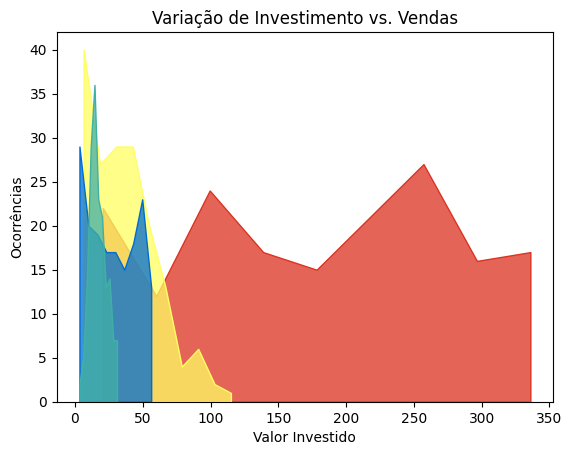

In [ ]:
# Histograma dos dados.
sns.histplot(data=dados, x="youtube", color="#DC3220", element="poly")
sns.histplot(data=dados, x="newspaper", color="#FEFE62", element="poly")
sns.histplot(data=dados, x="facebook", color="#006CD1", element="poly")
sns.histplot(data=dados, x="sales", color="#40B0A6", element="poly")
plt.ylabel("Ocorrências")
plt.xlabel("Valor Investido")
plt.title("Variação de Investimento vs. Vendas");

🟥 youtube | 🟨 newspaper | 🟦 facebook | 🟩 sales
### O esquema de cores do gráfico acima é inclusivo, pois contém tonalidades de cores para que pessoas com daltonismo possam ter a mesma experiência visual.

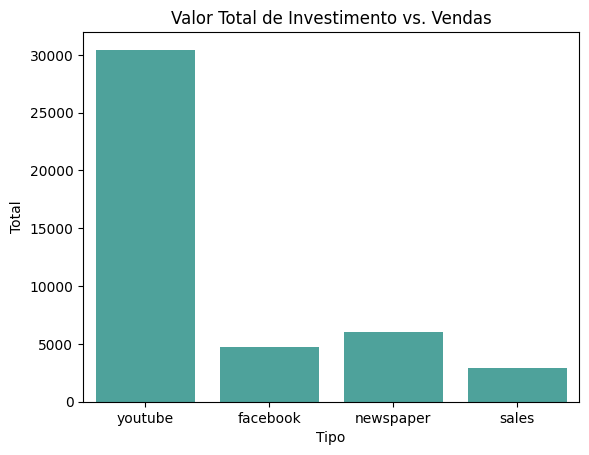

In [ ]:
# Montando o gráfico do total de cada coluna.
sns.barplot(data=dados_total, x='Tipo', y='Total', color="#40B0A6" );
plt.title("Valor Total de Investimento vs. Vendas");

### Qualidade dos dados


1.  A média dos valores da coluna youtube é **bem maior** que a soma das médias das outras colunas, ou seja, *Média Youtube > (Média Facebook + Média Newspaper + Média Sales)*.
2.  O desvio padrão da coluna youtube está acima de 100, o que representa uma **variação de valores muito grande** para investimentos em marketing, sendo este desvio muito mais condizente com a variação de receita de vendas (sales).
3.  A média de sales é a **mais baixa** e considerando os anos 20 do século XXI, onde o digital está muito acima das mídias offline, essa média parece mais consistente com os gastos em jornais (*\"newspaper"*).

### Tratamento dos dados

In [ ]:
# Renomeando as colunas do dataframe principal.
dados = dados.rename(columns={'youtube': 'sales', 'facebook': 'youtube', 'newspaper': 'facebook', 'sales': 'newspaper'})
dados.head()

,sales,youtube,facebook,newspaper
0,84.72,19.20,48.96,12.60
1,351.48,33.96,51.84,25.68
2,135.48,20.88,46.32,14.28
3,116.64,1.80,36.00,11.52
4,318.72,24.00,0.36,20.88


### Construção dos dados

Para facilitar o entendimento do comportamento das variáveis posteriormente, serão adicionadas duas colunas:

1.  Investimento, com a soma dos valores de youtube, facebook e newspaper;
2.  ROI (*Return Over Investment*), que será um cálculo feito em cima das variáveis anteriores na seguinte fórmula:

</br>
$$
ROI =\frac{sales-(youtube+facebook+newspaper)}{(youtube+facebook+newspaper)}
$$
</br>

In [ ]:
# Construindo a nova coluna 'investimento' no dataframe principal.
dados_alt = dados
dados_alt['investimento'] = dados_alt['youtube'] + dados_alt['facebook'] + dados_alt['newspaper']
dados_alt.head()

,sales,youtube,facebook,newspaper,investimento
0,84.72,19.20,48.96,12.60,80.76
1,351.48,33.96,51.84,25.68,111.48
2,135.48,20.88,46.32,14.28,81.48
3,116.64,1.80,36.00,11.52,49.32
4,318.72,24.00,0.36,20.88,45.24


In [ ]:
# Construindo a nova coluna 'ROI' no dataframe principal.
dados_alt['ROI'] = round((dados_alt['sales'] - dados_alt['investimento']) / dados_alt['investimento'], 2)
dados_alt.head()

,sales,youtube,facebook,newspaper,investimento,ROI
0,84.72,19.20,48.96,12.60,80.76,0.05
1,351.48,33.96,51.84,25.68,111.48,2.15
2,135.48,20.88,46.32,14.28,81.48,0.66
3,116.64,1.80,36.00,11.52,49.32,1.36
4,318.72,24.00,0.36,20.88,45.24,6.05


In [ ]:
# Atualizando o dataframe de totais sem o ROI.
dados_total = pd.DataFrame({'Tipo': dados_alt.columns, 'Total': dados_alt.sum()})
dados_total.drop(['ROI'], axis=0, inplace=True)
dados_total.reset_index(inplace=True)
dados_total = dados_total[['Tipo', 'Total']]
dados_total

,Tipo,Total
0,sales,30441.60
1,youtube,4731.84
2,facebook,6026.04
3,newspaper,2893.80
4,investimento,13651.68


## Análise exploratória dos dados

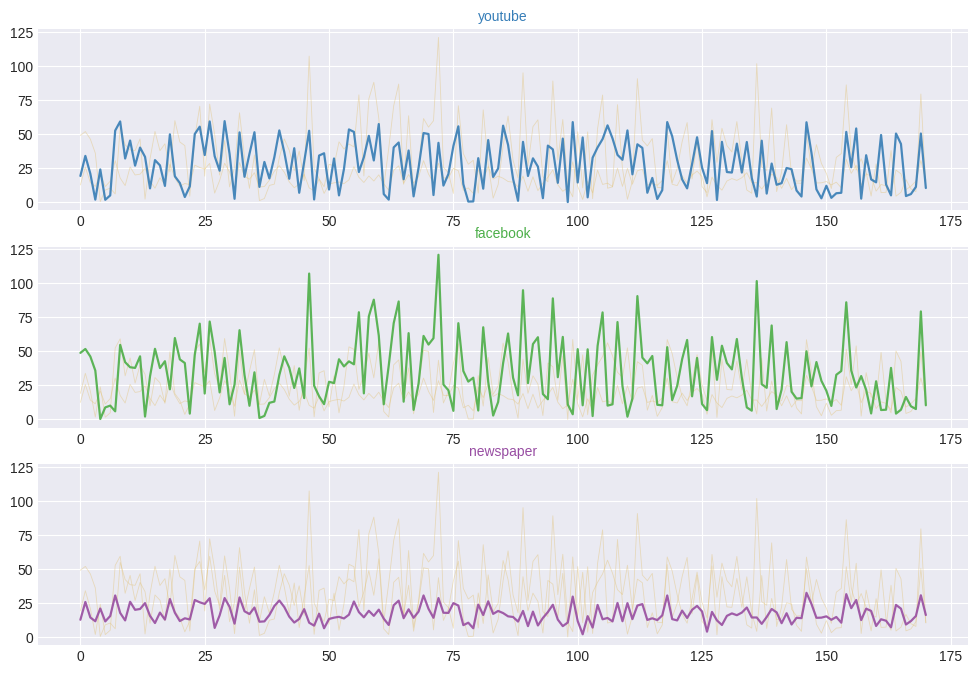

In [ ]:
# Tipos de investimento por gráfico de linha.
multi = dados_alt[['youtube', 'facebook', 'newspaper']]
plt.figure(figsize=(12,8))
plt.style.use('seaborn-v0_8-darkgrid')
palette = plt.get_cmap('Set1')
num = 0
for col in multi:
  num += 1
  plt.subplot(3, 1, num)
  for v in multi:
    plt.plot(multi.index, multi[v], marker='', color='#E1BE6A', linewidth=0.6, alpha=0.4)
  plt.plot(multi.index, multi[col], marker='', color=palette(num), linewidth=1.6, alpha=0.9, label=col)
  plt.title(col, loc='center', fontsize=10, fontweight=0, color=palette(num))
plt.show();

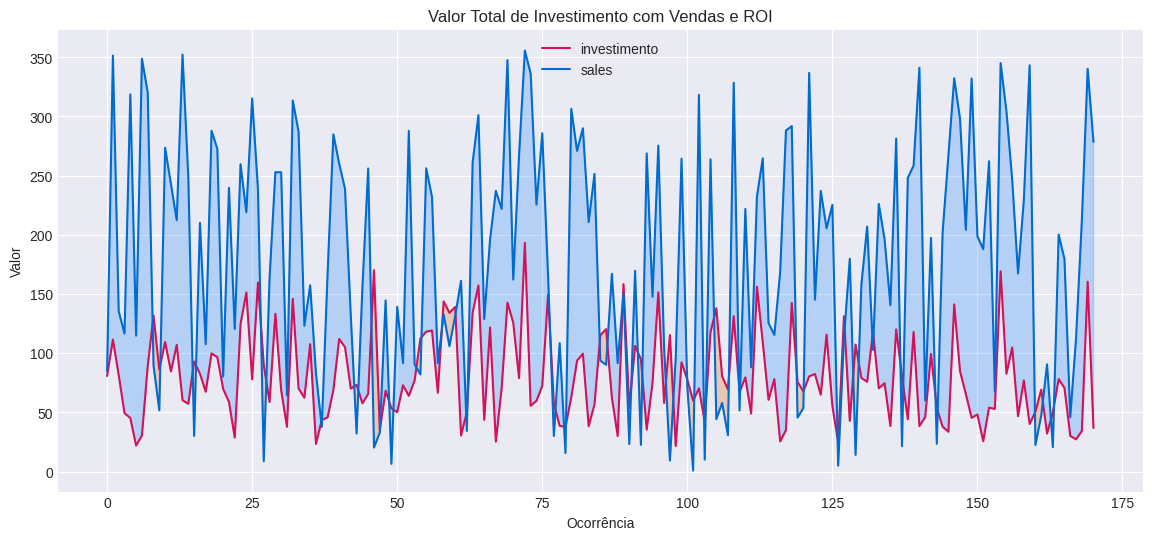

In [ ]:
# Configurando um gráfico preenchido de linhas com total de investimento sobre vendas.
fig, ay = plt.subplots(figsize=(14, 6))
sns.lineplot(data=dados_alt, x=dados_alt.index, y='investimento', color='#D41159', label='investimento')
sns.lineplot(data=dados_alt, x=dados_alt.index, y='sales', color='#006CD1', label='sales')
ay.fill_between(
    dados_alt.index, dados_alt['investimento'], dados_alt['sales'],
    where=(dados_alt['investimento'] > dados_alt['sales']),
    interpolate=True, color='#E66100', alpha=0.25
    )
ay.fill_between(
    dados_alt.index, dados_alt['investimento'], dados_alt['sales'],
    where=(dados_alt['investimento'] < dados_alt['sales']),
    interpolate=True, color='#1A85FF', alpha=0.25
    )
ay.legend()
plt.xlabel('Ocorrência')
plt.ylabel('Valor')
plt.title("Valor Total de Investimento com Vendas e ROI");

In [ ]:
# Verificação de relação entre as colunas em tabela.
dados_alt.corr()

,sales,youtube,facebook,newspaper,investimento,ROI
sales,1.000000,0.086538,0.110759,0.782030,0.242053,0.630784
youtube,0.086538,1.000000,0.293425,0.602918,0.759873,-0.456183
facebook,0.110759,0.293425,1.000000,0.254987,0.831638,-0.422037
newspaper,0.782030,0.602918,0.254987,1.000000,0.614250,0.160420
investimento,0.242053,0.759873,0.831638,0.614250,1.000000,-0.462523
ROI,0.630784,-0.456183,-0.422037,0.160420,-0.462523,1.000000


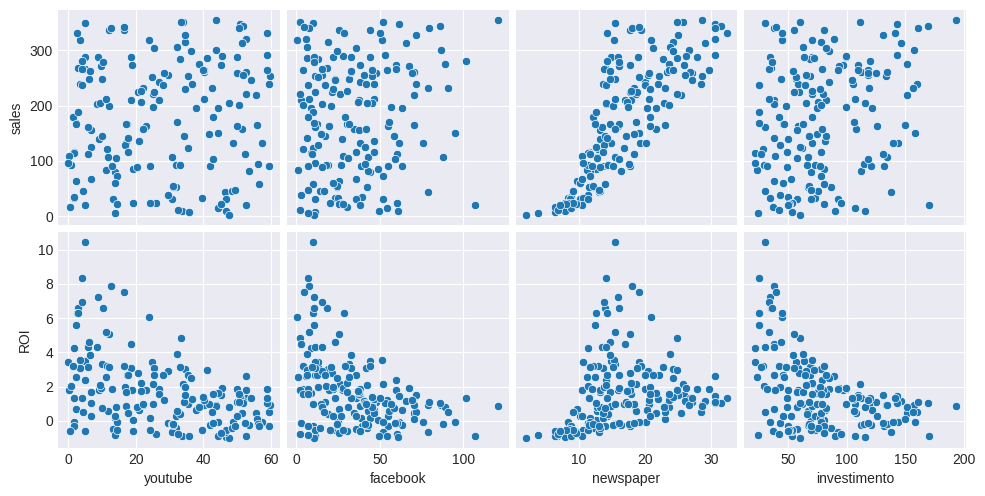

In [ ]:
# Verificando a relação entre as colunas em gráfico.
sns.pairplot(dados_alt, x_vars=['youtube', 'facebook', 'newspaper', 'investimento'], y_vars=['sales', 'ROI'], );

A influência do investimento em plataformas como YouTube e Facebook nas vendas é virtualmente insignificante. Além disso, em comparação com o retorno sobre o investimento (ROI), ambos os canais demonstram uma correlação negativa, indicando que quanto maior o investimento, menor o retorno.

A correlação mais significativa é observada no investimento em mídia impressa, onde há um aumento proporcional nas vendas e no ROI.

Portanto, a alocação de recursos publicitários é mais crucial do que a quantidade investida em si.

## Modelagem dos Dados

### Seleção do modelo
- O modelo selecionado para este projeto é o de Regressão Linear Simples, da biblioteca scikit-learn.

### Treinamento do modelo

O modelo será treinado separando o dataset tratado (*dados_alt*) em 4 variáveis:
*   Uma X de treino e uma X de teste;
*   Uma Y de treino e uma Y de teste.

In [ ]:
# Separação das variáveis X e Y.
X = dados_alt[['youtube', 'facebook', 'newspaper']]
Y = dados_alt['sales']

In [ ]:
# Separando as variáveis de treino e teste.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, random_state=22)

In [ ]:
# Chamando a regressão e treinando o modelo.
regL = LinearRegression()
regL.fit(X_train, Y_train)

LinearRegression()

### Teste do modelo

In [ ]:
# Testando o modelo.
model_teste = regL.predict(X_test)

In [ ]:
# Verificando a acurácia.
acuracia = r2_score(Y_test, model_teste)
print(f'A acurácia deste modelo é de {round(acuracia*100)}%.')

A acurácia deste modelo é de 91%.


### Resultado da acurácia

Após iterar e ajustar o modelo, a acurácia máxima alcançada foi de 91%, com 80% dos dados utilizados para o treinamento.

## Avaliação e Resultados do projeto

O projeto demonstrou resultados altamente satisfatórios em relação aos critérios de sucesso estabelecidos.

Em relação aos critérios de negócio, foi cumprido:

- Identificação das variáveis que apresentam correlação significativa com as vendas.

Quanto aos critérios do projeto, foram alcançados os seguintes marcos:

- Desenvolvimento de uma análise exploratória que ilustra a correlação (ou sua ausência) entre os investimentos e o retorno.

- Implementação de um modelo de regressão linear com uma precisão mínima de 90%.

### Revisão do processo

Todo o projeto passou pelas seguintes etapas:
1.  Entendimento dos dados que compunham o dataset
2.  Tratamento dos dados com alteração nos títulos da coluna
3.  Construção de duas novas colunas (investimento, ROI)
4.  Análise exploratória dos dados e suas correlações
5.  Treinamento e teste do modelo

### Possíveis ações futuras

Reestruturação o dataset e treinar o modelo com novas métricas.

### Conclusão

O projeto demonstrou resultados satisfatórios para o projeto requerido no desafio.










